<a href="https://colab.research.google.com/github/drahmel/google_public_colab/blob/main/CGP_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CGP Runnable Evaluation Model

Scoring / Emissions / Evaluation algo for the Conversation Genome Project


In [25]:
import json
import os
import random
from datetime import datetime, timezone
from traceback import print_exception

import torch

spacy = None
Matcher = None
try:
    import spacy
    from spacy.matcher import Matcher
except:
    print("Please install spacy to run locally")


import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt

import json
from IPython.display import HTML
from IPython.display import Code

def render_json(jstr):
  if type(jstr) != str:
    jstr = json.dumps(jstr)
  return HTML("""
<script src="https://rawgit.com/caldwell/renderjson/master/renderjson.js"></script>
<script>
renderjson.set_show_to_level(1)
document.body.appendChild(renderjson(%s))
new ResizeObserver(google.colab.output.resizeIframeToContent).observe(document.body)
</script>
""" % jstr)

def sort_dict_list(dict_list, key, ascending=True):
    """
    Sorts a list of dictionary objects based on the value of a dictionary element.
    :param dict_list: list of dictionaries
    :param key: key to sort by
    :return: sorted list of dictionaries
    """
    return sorted(dict_list, key=lambda x: x[key], reverse=not ascending)

class logging:
    time_format = '%Y-%m-%d %H:%M:%S'
    def debug(*args, **kwargs):
        now = datetime.now(timezone.utc)
        print(now.strftime(logging.time_format), "DEBUG", " | ", *args[1:], sep="  ")
    def info(*args, **kwargs):
        now = datetime.now(timezone.utc)
        print(now.strftime(logging.time_format), "INFO", " | ", *args[1:], sep="  ")
    def error(*args, **kwargs):
        now = datetime.now(timezone.utc)
        print(now.strftime(logging.time_format), "ERROR", " | ", *args[1:], sep="  ")

class llm_spacy:
    nlp = None
    verbose = False

    def get_nlp(self):
        nlp = self.nlp
        dataset = "en_core_web_lg"  # ~600mb
        if not nlp:
            # Manual download
            # python -m spacy download en_core_web_sm
            # Faster small and medium models:
            # en_core_web_sm and en_core_web_md

            if not spacy.util.is_package(dataset):
                print(f"Downloading spacy model {dataset}...")
                spacy.cli.download(dataset)
                print("Model {dataset} downloaded successfully!")

            nlp = spacy.load(dataset)
            print(f"Spacy {dataset} Vector dimensionality: {nlp.vocab.vectors_length}")
            self.nlp = nlp
        return nlp

    async def simple_text_to_tags(self, body, min_tokens=5):
        nlp = self.get_nlp()

        # Define patterns
        adj_noun_pattern = [{"POS": "ADJ"}, {"POS": "NOUN"}]
        pronoun_pattern = [{"POS": "PRON"}]
        unique_word_pattern = [{"POS": {"IN": ["NOUN", "VERB", "ADJ"]}, "IS_STOP": False}]

        # Initialize the Matcher with the shared vocabulary
        matcher = Matcher(nlp.vocab)
        matcher.add("ADJ_NOUN_PATTERN", [adj_noun_pattern])
        matcher.add("PRONOUN_PATTERN", [pronoun_pattern])
        matcher.add("UNIQUE_WORD_PATTERN", [unique_word_pattern])

        doc = nlp( body )
        if self.verbose:
            print("DOC", doc)
        matches = matcher(doc)
        matches_dict = {}
        for match_id, start, end in matches:
            span = doc[start:end]
            if self.verbose:
                print("Span text", span.text)
            matchPhrase = span.lemma_
            if len(matchPhrase) > min_tokens:
                if self.verbose:
                    print(f"Original: {span.text}, Lemma: {span.lemma_} Vectors: {span.vector.tolist()}")
                if not matchPhrase in matches_dict:
                    matches_dict[matchPhrase] = {"tag":matchPhrase, "count":0, "vectors":span.vector.tolist()}
                matches_dict[matchPhrase]['count'] += 1

        return matches_dict

    async def get_neighborhood(self, response, tag_count_ceiling=None):
        all_vectors = []
        count = 0
        for key, val in response.items():
            all_vectors.append(val['vectors'])
            count += 1
            if tag_count_ceiling and count > tag_count_ceiling:
                break
        if self.verbose:
            print("all_vectors",all_vectors )
        # Create a vector representing the entire content by averaging the vectors of all tokens
        if len(all_vectors) > 0:
            neighborhood_vector = np.mean(all_vectors, axis=0)
            return neighborhood_vector
        else:
            return None

    def score_vector_similarity(self, neighborhood_vectors, individual_vectors):
        # Calculate the similarity score between the neighborhood_vectors and the individual_vectors
        # If all vectors are 0.0, the vector wasn't found for scoring in the embedding score
        if np.all(individual_vectors==0):
            return 0
        # Calculate the cosine similarity between two sets of vectors
        similarity_score = np.dot(neighborhood_vectors, individual_vectors) / (np.linalg.norm(neighborhood_vectors) * np.linalg.norm(individual_vectors))
        #print(f"Similarity score between the content and the tag: {similarity_score}")
        return similarity_score



class MockBt:
    def __init__(self):
        self.logging = logging()

bt = MockBt()

def compare_arrays(arr1, arr2):
    result_dict = {}

    set1 = set(arr1)
    set2 = set(arr2)

    result_dict["both"] = list(set1.intersection(set2))
    result_dict["unique_1"] = list(set1.difference(set2))
    result_dict["unique_2"] = list(set2.difference(set1))

    return result_dict

class Evaluator:
    min_tags = 3

    async def evaluate(self, full_convo_tags=None, miner_responses=None, body=None, exampleList=None):
        if not miner_responses and exampleList:
            miner_responses = []
            for idx, examples in enumerate(exampleList):
                miner_responses.append({"uid":idx, "tags":examples})
        if not full_convo_tags and body:
            response = await llm.simple_text_to_tags(body, min_tokens=0)
            print(f"Found tags for main convesation: {list(response.keys())}")
            neighborhood_vector = await llm.get_neighborhood(response)
            full_convo_tags = list(response.keys())
        final_scores = []
        now = datetime.now(timezone.utc)
        num_responses = len(miner_responses)
        bt.logging.debug(f"Starting eval of {num_responses} responses ...")

        scores = torch.zeros(num_responses)
        zero_score_mask = torch.ones(num_responses)
        rank_scores = torch.zeros(num_responses)

        avg_ages = torch.zeros(num_responses)
        avg_age_scores = torch.zeros(num_responses)
        uniqueness_scores = torch.zeros(num_responses)
        credit_author_scores = torch.zeros(num_responses)

        max_avg_age = 0

        spot_check_id_dict = dict()

        # quick integrity check and get spot_check_id_dict
        utcnow = datetime.now(timezone.utc)
        for idx, miner_response in enumerate(miner_responses):
            try:
                # Make sure there are enough tags to make processing worthwhile
                if miner_response is None or not miner_response or len(miner_response['tags']) < self.min_tags:
                    bt.logging.info(f"Only {len(miner_response['tags'])} tag(s) found for miner {miner_response['uid']}. Skipping.")
                    zero_score_mask[idx] = 0
                    continue
                diff = compare_arrays(full_convo_tags, miner_response['tags'])
                bt.logging.debug(f"uid: {miner_response['uid']} Both tag(s) count:{len(diff['both'])} / Miner unique: {diff['unique_2']} ")
            except Exception as e:
                bt.logging.error(f"Error while intitial checking {idx}-th response: {e}, 0 score")
                bt.logging.debug(print_exception(type(e), e, e.__traceback__))
                zero_score_mask[idx] = 0
            # Loop through tags that match the full convo and get the scores for those
            # These are de-emphasized -- they are more for validation
            both_tag_scores = []
            tag_count_ceiling = 5
            for tag in diff['both']:
                resp2 = await llm.simple_text_to_tags(tag, min_tokens=0)
                if len(resp2.keys()) == 0:
                    print(f"No vectors found for tag '{tag}'. Score of 0.")
                    both_tag_scores.append(0)
                    continue
                neighborhood_vector2 = await llm.get_neighborhood(resp2, tag_count_ceiling=tag_count_ceiling)
                #print("neighborhood_vector2", neighborhood_vector2)
                score = llm.score_vector_similarity(neighborhood_vector, neighborhood_vector2)
                both_tag_scores.append(score)
                print("Score", tag, score)
            if len(both_tag_scores) > 0:
                both_tag_scores_avg = np.mean(both_tag_scores)
                both_tag_scores_median = np.median(both_tag_scores)
            else:
                both_tag_scores_avg = 0.0
                both_tag_scores_median = 0.0
            # Calculate unique tags and then take to top 20
            unique_tag_scores = []
            for tag in diff['unique_2']:
                unique_tag_scores.append(self.get_full_convo_tag_score(tag))
            unique_tag_scores_avg = np.mean(unique_tag_scores)

            # TODO: Take full convo tags and generate semantic neighborhood
            # Figure out standard deviation for vectors in neighboardhood
            #       Test each unique term against neighboard -- how many SDs does term similarity score?
            # Weight score on SD similarity scores

            final_score = (both_tag_scores_avg * 0.3) + (unique_tag_scores_avg * 0.7)
            bt.logging.debug(f"Final score: {final_score} Both score avg: {both_tag_scores_avg} Unique score avg: {unique_tag_scores_avg}")
            final_scores.append(final_score)

        bt.logging.debug("Complete eval.", final_scores)

        return final_scores

    def get_full_convo_tag_score(self, tag):
        return 0.9

    async def calc_scores(self, ground_tags, neighborhood_vector, tags):
        scores = []
        scores_both = []
        scores_unique = []
        tag_count_ceiling = 5
        # Remove duplicate tags
        tag_set = list(set(tags))
        diff = compare_arrays(ground_tags, tag_set)
        for tag in tag_set:
            is_unique = False
            resp2 = await llm.simple_text_to_tags(tag, min_tokens=0)
            if tag in diff['unique_2']:
                is_unique = True
            #print(example, resp2)
            if len(resp2.keys()) == 0:
                print(f"No vectors found for tag '{tag}'. Score of 0. Unique: {is_unique}")
                scores.append(0)
                if is_unique:
                    scores_unique.append(0)
                else:
                    scores_both.append(0)
                continue
            neighborhood_vector2 = await llm.get_neighborhood(resp2, tag_count_ceiling=tag_count_ceiling)
            #print("neighborhood_vector2", neighborhood_vector2)
            score = llm.score_vector_similarity(neighborhood_vector, neighborhood_vector2)
            scores.append(score)
            if is_unique:
                scores_unique.append(score)
            else:
                scores_both.append(score)
            print(f"Score for {tag}: {score} -- Unique: {is_unique}")

        return (scores, scores_both, scores_unique)


# Testing Framework

Run the cell below to test scores against various keywords and content.

Setting up test data...
Running basic spacy keyword test...
Spacy en_core_web_lg Vector dimensionality: 300
Found tags for main conversation: ['today', 'lunch', 'I', 'decide', 'colorful', 'healthy', 'healthy meal', 'meal', 'start', 'bowl', 'mixed', 'mixed green', 'green', 'top', 'cherry', 'tomato', 'cucumber', 'slice', 'avocado', 'love', 'incorporate', 'fruit', 'vegetable', 'my', 'they', 'pack', 'vitamin', 'mineral', 'that', 'essential', 'our', 'body', 'fresh', 'crisp', 'crisp vegetable', 'add', 'nice', 'nice crunch', 'crunch', 'salad', 'make', 'it', 'refreshing', 'satisfying', 'satisfying choice', 'choice', 'grill', 'chicken', 'wrap', 'steamed', 'steamed broccoli', 'broccoli', 'fill', 'tender', 'juicy', 'lettuce', 'drizzle', 'ranch', 'dressing', 'perfect', 'perfect balance', 'balance', 'protein', 'veggie', 'rounded', 'rounded meal', 'great', 'great addition', 'addition', 'provide', 'good', 'good source', 'source', 'fiber', 'other nutrient', 'nutrient', 'satisfy', 'sweet', 'sweet tooth

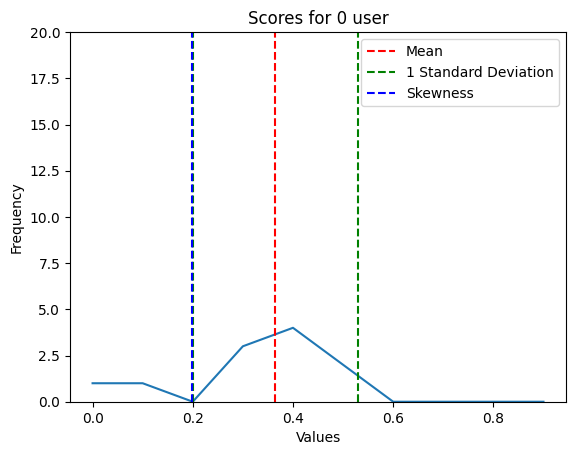

__________Tags: 11 Unique Tags: 9 Median score: 0.41310473897255745 Mean score: 0.3644182546089088 Skewness: -1.0029624633326066 Min: 0.0 Max: 0.5783620366582738


__________________ User 1 __________________
Score for dinner: 0.41310473897255745 -- Unique: True
Score for desert: 0.30495636508659524 -- Unique: True
Score for banana: 0.4701884963596046 -- Unique: True
Score for meal: 0.5150255571563305 -- Unique: False
Score for beef: 0.42101549555771134 -- Unique: True
Score for apple: 0.5783620366582738 -- Unique: True
Score for lunch: 0.3877007476492941 -- Unique: False
Score for broccoli: 0.520562137865622 -- Unique: False
Score for strawberries: 0.7373332365485278 -- Unique: True
Score for pear: 0.46838481152803363 -- Unique: True


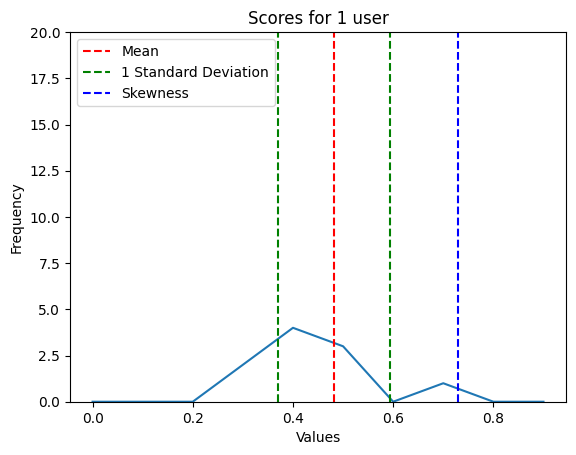

__________Tags: 10 Unique Tags: 7 Median score: 0.4692866539438191 Mean score: 0.481663362338255 Skewness: 0.7639702316103163 Min: 0.30495636508659524 Max: 0.7373332365485278


__________________ User 2 __________________
Score for airliner: 0.11081833776895221 -- Unique: True
Score for political party: 0.3136780510763804 -- Unique: True
Score for akjsdkajsdlkajl: 0 -- Unique: True


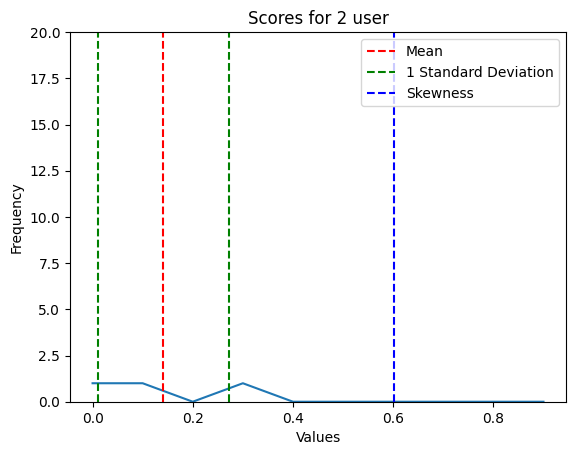

__________Tags: 3 Unique Tags: 3 Median score: 0.11081833776895221 Mean score: 0.14149879628177756 Skewness: 0.34114342550628174 Min: 0.0 Max: 0.3136780510763804


__________________ User 3 __________________
Score for passengers: 0.25594091260951285 -- Unique: True
Score for airplane mode: 0.30899954402065677 -- Unique: True
Score for pilots: 0.1777141379028095 -- Unique: True
Score for aircraft: 0.22514537042156058 -- Unique: True
Score for turbulence: 0.39112642442289364 -- Unique: True
Score for landing: 0.40183895462650804 -- Unique: True
Score for flight attendants: 0.38086554665422506 -- Unique: True
Score for emergency exits: 0.19440219823452423 -- Unique: True
Score for takeoff: 0.21350220050292532 -- Unique: True
Score for aviation: 0.23749530468529537 -- Unique: True
Score for cabin crew: 0.13946037398233058 -- Unique: True
Score for altitude: 0.320723375037466 -- Unique: True
Score for jet engines: 0.2133465077315869 -- Unique: True
Score for boarding: 0.36779234613780487 -

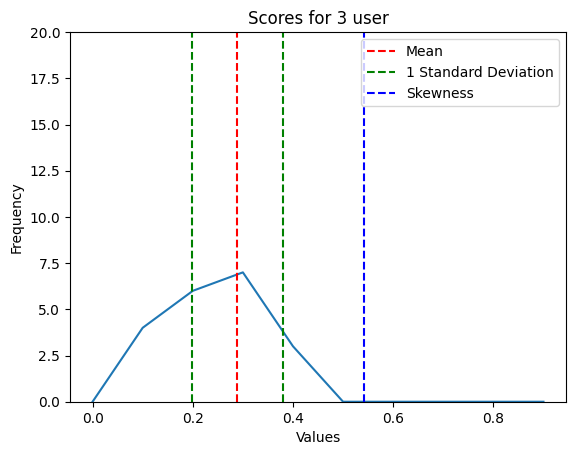

__________Tags: 20 Unique Tags: 20 Median score: 0.28024978667437667 Mean score: 0.2890633532767491 Skewness: 0.14201864886425944 Min: 0.13946037398233058 Max: 0.4535560482325156


__________________ User 4 __________________
Score for plum: 0.45494829056957536 -- Unique: True
Score for apple: 0.5783620366582738 -- Unique: True
Score for fruit: 0.6229028233254433 -- Unique: False
Score for coconut: 0.5541443017623823 -- Unique: True
Score for pear: 0.46838481152803363 -- Unique: True
Score for grape: 0.49615124359742674 -- Unique: False
No vectors found for tag 'blueberry'. Score of 0. Unique: False
No vectors found for tag 'orange'. Score of 0. Unique: True
Score for peach: 0.6336297223328927 -- Unique: True
Score for fig: 0.28487717297727255 -- Unique: True
Score for kiwi: 0.3018691076155214 -- Unique: True
Score for lime: 0.4315120411798434 -- Unique: True
Score for strawberry: 0.6283654174574028 -- Unique: False
Score for watermelon: 0.6119351863999802 -- Unique: True
Score for che

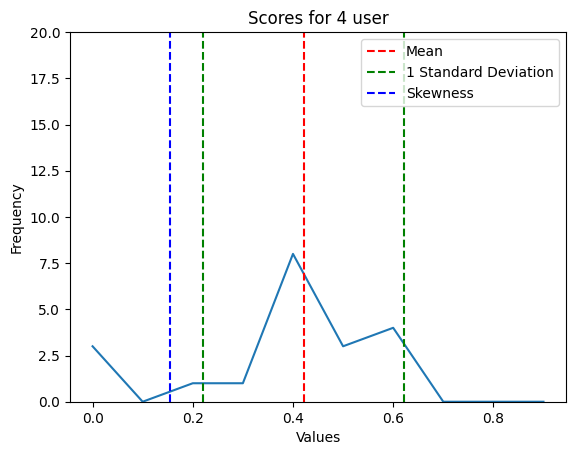

__________Tags: 20 Unique Tags: 15 Median score: 0.46293082425879484 Mean score: 0.4215424923515835 Skewness: -1.1540233703987828 Min: 0.0 Max: 0.6336297223328927


__________________ User 5 __________________
Score for takeout: 0.35945011981202946 -- Unique: True
No vectors found for tag 'cafeteria'. Score of 0. Unique: True
Score for picnic: 0.16411505872807527 -- Unique: True
Score for leftovers: 0.5764435478383493 -- Unique: True
Score for salad: 0.4872228405543312 -- Unique: False
Score for lunch break: 0.5316738884708286 -- Unique: True
No vectors found for tag 'vegetarian'. Score of 0. Unique: True
Score for comfort food: 0.5916129221743575 -- Unique: True
Score for gluten-free: 0.5441461271680634 -- Unique: True
Score for fast food: 0.6273278634136663 -- Unique: True
Score for brunch: 0.37832784302482786 -- Unique: True
Score for sandwich: 0.46295457862681316 -- Unique: True
Score for bag lunch: 0.3728847681105704 -- Unique: True
Score for meal: 0.5150255571563305 -- Unique: Fa

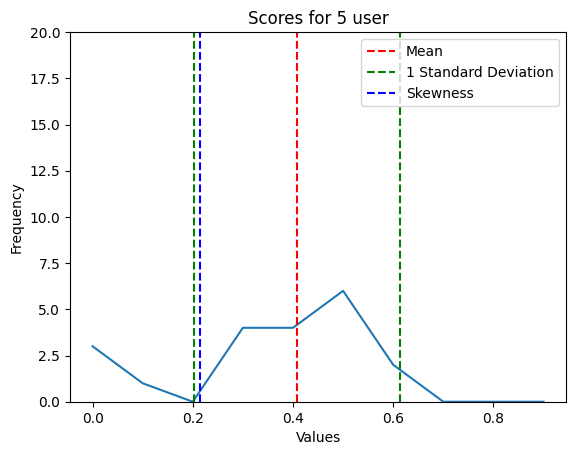

__________Tags: 20 Unique Tags: 16 Median score: 0.46314043500187596 Mean score: 0.40831533221061245 Skewness: -0.9525376323468328 Min: 0.0 Max: 0.6826538652114169


__________________ User 6 __________________
Score for apple: 0.5783620366582738 -- Unique: True
Score for akjsdkajsdlkajl: 0 -- Unique: True


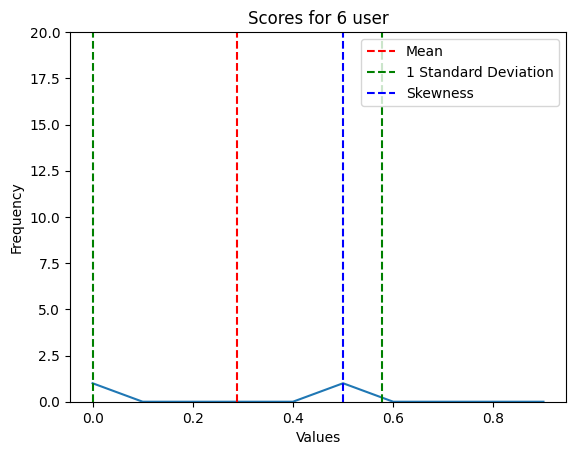

__________Tags: 15 Unique Tags: 2 Median score: 0.2891810183291369 Mean score: 0.2891810183291369 Skewness: 0.0 Min: 0.0 Max: 0.5783620366582738


__________________ User 7 __________________
No vectors found for tag 'akjsdkajsdlkajl6'. Score of 0. Unique: True
Score for akjsdkajsdlkajl4: 0 -- Unique: True
No vectors found for tag 'akjsdkajsdlkajl3'. Score of 0. Unique: True
No vectors found for tag 'akjsdkajsdlkajl5'. Score of 0. Unique: True
Score for apple: 0.5783620366582738 -- Unique: True
No vectors found for tag 'akjsdkajsdlkajl2'. Score of 0. Unique: True
No vectors found for tag 'akjsdkajsdlkajl7'. Score of 0. Unique: True
No vectors found for tag 'akjsdkajsdlkajl8'. Score of 0. Unique: True
No vectors found for tag 'akjsdkajsdlkajl1'. Score of 0. Unique: True


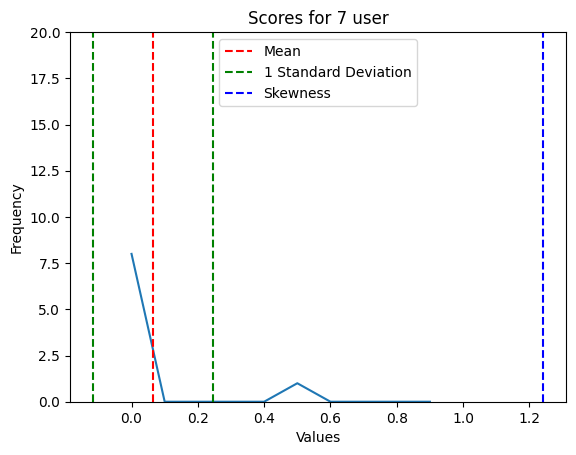

__________Tags: 9 Unique Tags: 9 Median score: 0.0 Mean score: 0.06426244851758597 Skewness: 2.474873734152917 Min: 0.0 Max: 0.5783620366582738


__________________ User 8 __________________
No vectors found for tag 'akjsdkajsdlkajl6'. Score of 0. Unique: True
Score for akjsdkajsdlkajl4: 0 -- Unique: True
No vectors found for tag 'akjsdkajsdlkajl3'. Score of 0. Unique: True
No vectors found for tag 'akjsdkajsdlkajl5'. Score of 0. Unique: True
Score for clock: 0.22318836656371965 -- Unique: True
No vectors found for tag 'akjsdkajsdlkajl2'. Score of 0. Unique: True
No vectors found for tag 'akjsdkajsdlkajl7'. Score of 0. Unique: True
No vectors found for tag 'akjsdkajsdlkajl8'. Score of 0. Unique: True
No vectors found for tag 'akjsdkajsdlkajl1'. Score of 0. Unique: True


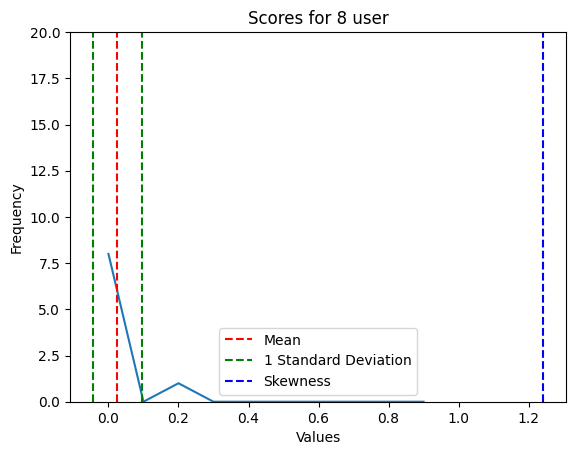

__________Tags: 9 Unique Tags: 9 Median score: 0.0 Mean score: 0.02479870739596885 Skewness: 2.4748737341529163 Min: 0.0 Max: 0.22318836656371965
Complete. Score sets:


In [27]:
print("Setting up test data...")

body = """Today for lunch, I decided to have a colorful and healthy meal. I started off with a bowl of mixed greens, topped with some cherry tomatoes, cucumbers, and sliced avocado. I love incorporating fruits and vegetables into my meals as they are packed with vitamins and minerals that are essential for our bodies. The fresh and crisp vegetables added a nice crunch to my salad, making it a refreshing and satisfying choice.
Next, I had a grilled chicken wrap with a side of steamed broccoli. The wrap was filled with tender and juicy chicken, lettuce, tomatoes, and a drizzle of ranch dressing. It was a perfect balance of protein and veggies, making it a well-rounded meal. The steamed broccoli was a great addition as it provided a good source of fiber and other nutrients.
To satisfy my sweet tooth, I had a bowl of mixed fruit for dessert. It had a variety of fruits such as strawberries, blueberries, and grapes. Not only did it add some natural sweetness to my meal, but it also provided me with a boost of antioxidants and other beneficial nutrients.
Eating a nutritious and balanced lunch not only keeps me physically healthy but also helps me stay focused and energized for the rest of the day. It's important to make conscious choices and incorporate fruits and vegetables into our meals to maintain a healthy diet. After finishing my lunch, I felt satisfied and ready to tackle the rest of my day with a renewed sense of energy."""

tagLists = [
    # Mostly relevant, with a few irrelevant tags
    ["apple", "lunch", "automobile", "banana", "pear", "dinner", "meal", "beef", "akjsdkajsdlkajl", "political party", "airliner"],
    # Tags close to target
    ["apple", "lunch", "banana", "pear", "dinner", "meal", "beef", "desert", "broccoli", "strawberries"],
    # Few tags, all irrelevant
    ["akjsdkajsdlkajl", "political party", "airliner"],
    # Many tags, all irrelevant
    ["aircraft", "aviation", "flight", "passengers", "pilots", "cockpit", "air traffic control", "takeoff", "landing", "jet engines", "altitude", "airlines", "airports", "flight attendants", "airplane mode", "airworthiness", "boarding", "turbulence", "emergency exits", "cabin crew"],
    # Food tags, not directly related to ground text (lunch)
    ["fruit", "apple", "orange", "banana", "grape", "strawberry", "mango", "watermelon", "pineapple", "kiwi", "peach", "plum", "cherry", "pear", "blueberry", "raspberry", "lemon", "lime", "fig", "coconut"],
    # Meal tags
    ["lunch", "food", "meal", "dining", "restaurant", "sandwich", "salad", "soup", "fast food", "takeout", "brunch", "picnic", "cafeteria", "lunch break", "healthy", "comfort food", "bag lunch", "leftovers", "vegetarian", "gluten-free"],
    # Duplicate tags and 1 irrelevant tags -- so 2 tags, 1 relevant and 1 irrelevant
    ["apple", "apple", "apple", "apple", "apple", "apple", "apple", "apple", "apple", "apple", "apple", "apple", "apple", "apple", "akjsdkajsdlkajl"],
    # Many non-sense tags (no latent space location) and 1 very relevant tag
    ["apple", "akjsdkajsdlkajl1", "akjsdkajsdlkajl2", "akjsdkajsdlkajl3", "akjsdkajsdlkajl4", "akjsdkajsdlkajl5", "akjsdkajsdlkajl6", "akjsdkajsdlkajl7", "akjsdkajsdlkajl8"],
    # Many non-sense tags (no latent space location) and 1  irrelevant tag
    ["clock", "akjsdkajsdlkajl1", "akjsdkajsdlkajl2", "akjsdkajsdlkajl3", "akjsdkajsdlkajl4", "akjsdkajsdlkajl5", "akjsdkajsdlkajl6", "akjsdkajsdlkajl7", "akjsdkajsdlkajl8"],
]
miner_tag_lists = tagLists

async def calculate_penalty(score, num_tags, num_unique_tags,  min_score, max_score):
    final_score = score
    # All junk tags. Penalize
    if max_score < .2:
        final_score *= 0.5
    # Very few tags. Penalize.
    if num_tags < 2:
        final_score *= 0.2
    if num_unique_tags < 1:
        final_score *= 0.3
    return score

async def calculate_final_scores(ground_tags, miner_tag_lists):
    e = Evaluator()
    # Find the max tags returned for the y-axis of the plot
    max_len = len(max(miner_tag_lists, key=len))
    print("max_len", max_len)
    scoreData = []
    for idx, tags in enumerate(miner_tag_lists):
        print(f"\n\n__________________ User {idx} __________________")
        skewness = 0
        results = await e.calc_scores(ground_tags, neighborhood_vector, tags)
        (scores, scores_both, scores_unique) = results

        mean_score = np.mean(scores)
        median_score = np.median(scores)
        freq, bins = np.histogram(scores, bins=10, range=(0,1))
        #skewness = skew(freq)
        skewness = skew(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)


        #y1 =  sorted(scores)
        #print(scores)
        freq, bins = np.histogram(scores, bins=10, range=(0,1))
        mean = np.mean(scores)
        std = np.std(scores)
        plt.plot(bins[:-1], freq)
        plt.axvline(mean, color='r', linestyle='--', label='Mean')
        plt.axvline(mean + std, color='g', linestyle='--', label='1 Standard Deviation')
        plt.axvline(mean - std, color='g', linestyle='--')

        # Adjust the skewness so 0 is in the center of the graph
        skewness_x = 0.5 + (0.3 * skewness)
        plt.axvline(skewness_x, color='b', linestyle='--', label='Skewness')

        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.legend()
        plt.ylim(0,max_len)

        #y1 =  scores
        #plt.plot(x, y1, label="line L")
        #plt.plot()

        plt.title(f"Scores for {idx} user")
        plt.show()

        # SCORING FUNCTION
        adjusted_score = (
            (0.7 * median_score) +
            (0.3 * mean_score)
        ) / 2
        final_score = await calculate_penalty(adjusted_score, len(scores), len(scores_unique), min_score, max_score)

        scoreData.append({"uid": idx, "adjustedScore":adjusted_score, "final_score":final_score, "tags":tags})

        print(f"__________Tags: {len(tags)} Unique Tags: {len(scores_unique)} Median score: {median_score} Mean score: {mean_score} Skewness: {skewness} Min: {min_score} Max: {max_score}" )
    print("Complete. Score sets:")
    scoreData = sort_dict_list(scoreData, "adjustedScore", ascending=False)
    Code(json.dumps(scoreData, indent=4))
    #render_json()

print("Running basic spacy keyword test...")
llm = llm_spacy()
response = await llm.simple_text_to_tags(body, min_tokens=0)
ground_tags = list(response.keys())
print(f"Found tags for main conversation: {ground_tags}")
neighborhood_vector = await llm.get_neighborhood(response)
#print("neighborhood_vector", neighborhood_vector)
print("Processing tag sets...")
await calculate_final_scores(ground_tags, miner_tag_lists)


# Full Evaluator run

Run this to execute the full validator routine as if miners returns valuations

In [ ]:

body = """Today for lunch, I decided to have a colorful and healthy meal. I started off with a bowl of mixed greens, topped with some cherry tomatoes, cucumbers, and sliced avocado. I love incorporating fruits and vegetables into my meals as they are packed with vitamins and minerals that are essential for our bodies. The fresh and crisp vegetables added a nice crunch to my salad, making it a refreshing and satisfying choice.
Next, I had a grilled chicken wrap with a side of steamed broccoli. The wrap was filled with tender and juicy chicken, lettuce, tomatoes, and a drizzle of ranch dressing. It was a perfect balance of protein and veggies, making it a well-rounded meal. The steamed broccoli was a great addition as it provided a good source of fiber and other nutrients.
To satisfy my sweet tooth, I had a bowl of mixed fruit for dessert. It had a variety of fruits such as strawberries, blueberries, and grapes. Not only did it add some natural sweetness to my meal, but it also provided me with a boost of antioxidants and other beneficial nutrients.
Eating a nutritious and balanced lunch not only keeps me physically healthy but also helps me stay focused and energized for the rest of the day. It's important to make conscious choices and incorporate fruits and vegetables into our meals to maintain a healthy diet. After finishing my lunch, I felt satisfied and ready to tackle the rest of my day with a renewed sense of energy."""

# Example of miner responses structure:
miner_responses = [
    {"uid":1, "tags":["food", "banana", "pear"]},
]

e = Evaluator()
bt.logging.info("SCORES", await e.evaluate(body=body, exampleList=exampleList))


Found tags for main convesation: ['today', 'lunch', 'I', 'decide', 'colorful', 'healthy', 'healthy meal', 'meal', 'start', 'bowl', 'mixed', 'mixed green', 'green', 'top', 'cherry', 'tomato', 'cucumber', 'slice', 'avocado', 'love', 'incorporate', 'fruit', 'vegetable', 'my', 'they', 'pack', 'vitamin', 'mineral', 'that', 'essential', 'our', 'body', 'fresh', 'crisp', 'crisp vegetable', 'add', 'nice', 'nice crunch', 'crunch', 'salad', 'make', 'it', 'refreshing', 'satisfying', 'satisfying choice', 'choice', 'grill', 'chicken', 'wrap', 'steamed', 'steamed broccoli', 'broccoli', 'fill', 'tender', 'juicy', 'lettuce', 'drizzle', 'ranch', 'dressing', 'perfect', 'perfect balance', 'balance', 'protein', 'veggie', 'rounded', 'rounded meal', 'great', 'great addition', 'addition', 'provide', 'good', 'good source', 'source', 'fiber', 'other nutrient', 'nutrient', 'satisfy', 'sweet', 'sweet tooth', 'tooth', 'mixed fruit', 'dessert', 'variety', 'strawberry', 'blueberry', 'grape', 'natural', 'natural swee

hello


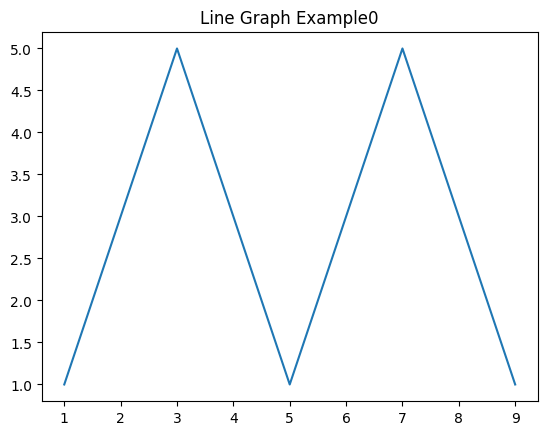

hello


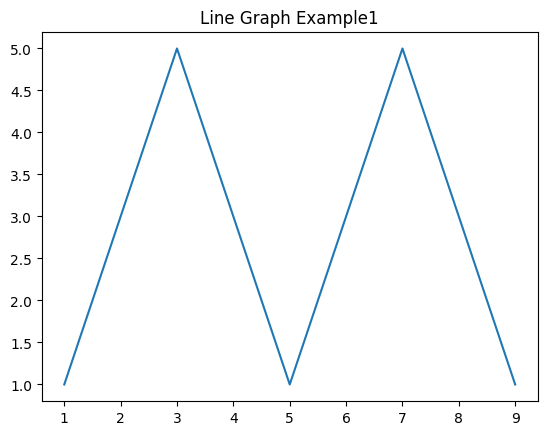

hello


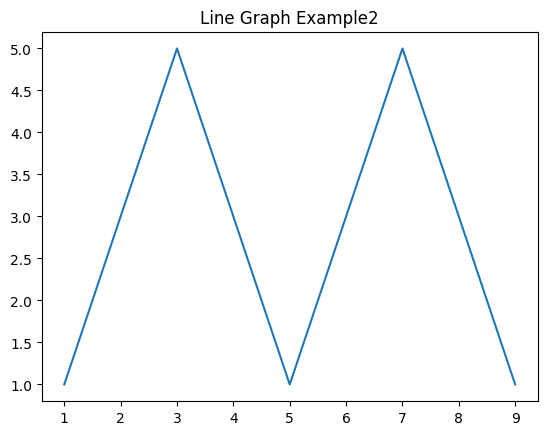

hello


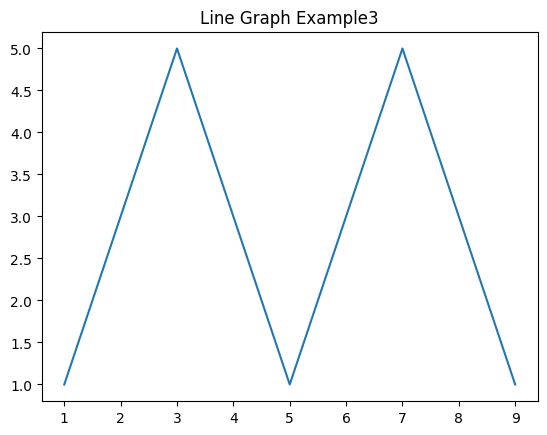

hello


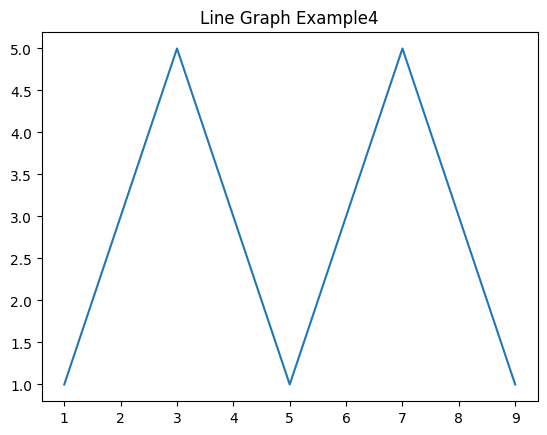

In [ ]:
import matplotlib.pyplot as plt
for i in range(0,5):
    x  = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    y1 = [1, 3, 5, 3, 1, 3, 5, 3, 1]
    plt.plot(x, y1, label="line L")
    plt.plot()
    print("hello")

    #plt.xlabel("x axis")
    #plt.ylabel("y axis")
    plt.title("Line Graph Example"+str(i))
    #plt.legend()
    plt.show()
